# 4.1: Depth-first search
* Finds all vertices of a graph that can be reached from the start
* Paths represented by search tree
* Not guarenteed to be the shortest path

Dist b/t nodes is the length of the shortest path

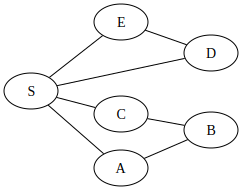

In [1]:
from graphviz import Graph

graph = Graph(graph_attr={"rankdir":"LR"})

nodes = set("EDSCAB")
adj = {
    "E": set(("D", "S")),
    "D": set(("E", "S")),
    "S": set(("E", "D", "C", "A")),
    "C": set(("S", "B")),
    "A": set(("S", "B")),
    "B": set(("C", "A"))
}

edges = {frozenset((u,v)) for u,neighbors in adj.items() for v in neighbors}

for node in nodes:
    graph.node(node, node)

for u,v in edges:
    graph.edge(u,v)

graph

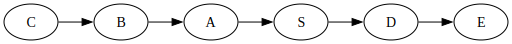

In [2]:
from graphviz import Digraph

def dfs(start, adj):
    dfs_tree = {}
    to_visit = [(None, start)]

    while to_visit:
        u,v = to_visit.pop()
        if v not in dfs_tree:
            dfs_tree[v] = u
            for neighbor in adj[v]:
                to_visit.append((v, neighbor))

    return dfs_tree

dfs_tree = dfs("C", adj)

def tree_to_graph(tree):
    graph = Digraph(graph_attr={"rankdir": "LR"})
    for v,u in tree.items():
        if u is not None:
            graph.node(u)
            graph.edge(u,v)
    return graph

tree_to_graph(dfs_tree)

# 4.2: Breadth-first search
* Uses queue (FIFO) insead of stack (LIFO) for DFS
* Visits all neighbors (dist 1), then neighbors of neighbors (dist 2)...
* BFS tree is a shortest path tree, guarenteed to be shortest path

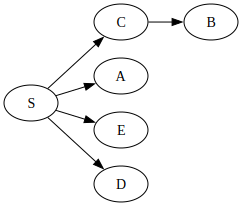

In [3]:
from queue import Queue

def bfs(start, adj):
    bfs_tree = {}
    to_visit = Queue()
    to_visit.put((None, start))

    while not to_visit.empty():
        u,v = to_visit.get()
        if v not in bfs_tree:
            bfs_tree[v] = u
            for neighbor in adj[v]:
                to_visit.put((v, neighbor))

    return bfs_tree

bfs_tree = bfs("S", adj)

tree_to_graph(bfs_tree)

In [4]:
def bfs_dists(start, adj):
    dists = {start: 0}

    to_visit = Queue()
    to_visit.put(start)

    while not to_visit.empty():
        v = to_visit.get()
        for neighbor in adj[v]:
            if neighbor not in dists:
                dists[neighbor] = dists[v] + 1
                to_visit.put(neighbor)

    return dists

dists = bfs_dists("S", adj)
print(dists)

{'S': 0, 'C': 1, 'A': 1, 'E': 1, 'D': 1, 'B': 2}


## BFS proof
Show for each $d = 0, 1, 2...$, there must be a moment where:
1. All nodes w/ dist $\le d$ from $s$ have their dists set correctly
2. All node w/ dist $> d$ have dist $= \infty$
3. Queue $Q$ contains exactly nodes at dist $d$

#### Proof by induction:
Base case: at $d = 0$
1. Node $s$ has dist $d = 0$
2. All other nodes have dist $= \infty$
3. Queue $Q$ contains only $s$, the only node at dist $d = 0$

Inductive hypothesis:
* Assume that for $d = k$
    1. All nodes w/ $d \le k$ have their dists set correctly
    2. All nodes w/ dist $> k$ have dist $= \infty$
    3. Queue $Q$ contains exactly nodes at dist $k$
* Show the 3 conditions for $d = k+1$

Inductive step:  
Following the BFS algorithm, for each node in $Q$ (only contains nodes at dist $k$): remove the node from $Q$, and for each neighboring node, check if the distance is $\infty$. The distance will only be $\infty$ if it has a dist $d > k$, since dists of all nodes w/ $d \le k$ are already set correctly. If the distance if $\infty$, then we know that we have not yet seen that node yet, and its distance will be set to $k+1$ and it will be added to the queue.  
After processing all nodes of distance $d$:
1. All nodes w/ $d \le k+1$ have their dists set correctly since we set newly discovered node dists to $k+1$ and previously all nodes w/ $d \le k$ had dists set correctly.
2. All nodes w/ dist $> k+1$ have dist $= \infty$ since we have only set nodes of dist $k+1$.
3. Queue $Q$ contains exactly nodes at dist $k+1$ since we removed all nodes of dist $k$ and added all nodes of dist $k+1$

$QED$

Runtime is $O(|V|+|E|)$, same as DFS. Each visitable vertex is visited once, and each edge touching the vertex is taken.

DFS goes deep into the graph, backtracking when there are no more new nodes to visit.

BFS visits nodes in order of their distance to the starting point. Wave propagating from the starting node.

# 4.3: Lengths on edges